In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [4]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [5]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [6]:
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['phone'].fillna('Unknown', inplace=True)


In [7]:
df.isnull().sum().sum()

0

In [8]:
import datetime as dt

# Convert dates to datetime format
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Create retention variable (active in the last 30 days)
last_trip_cutoff = df['last_trip_date'].max() - pd.Timedelta(days=30)
df['retained'] = df['last_trip_date'] >= last_trip_cutoff

In [9]:
# Create account age feature
df['account_age'] = (df['last_trip_date'] - df['signup_date']).dt.days

# Create days since last trip feature
df['days_since_last_trip'] = (df['last_trip_date'].max() - df['last_trip_date']).dt.days


In [10]:
# One-hot encode the city column
df = pd.get_dummies(df, columns=['city'], drop_first=True)

In [11]:
# One-hot encode the phone column
df = pd.get_dummies(df, columns=['phone'], drop_first=True)

In [12]:
# Create binary feature for high surge pricing (> 1.5 surge multiplier)
df['high_surge_flag'] = df['avg_surge'] > 1.5

In [13]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,account_age,days_since_last_trip,city_King's Landing,city_Winterfell,phone_Unknown,phone_iPhone,high_surge_flag
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,True,143,14,True,False,False,True,False
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,False,96,57,False,False,False,False,False
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,False,1,175,False,False,False,True,False
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,True,170,2,True,False,False,True,False
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,False,47,108,False,True,False,False,False


In [16]:
df.isnull().sum().sum()

0

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

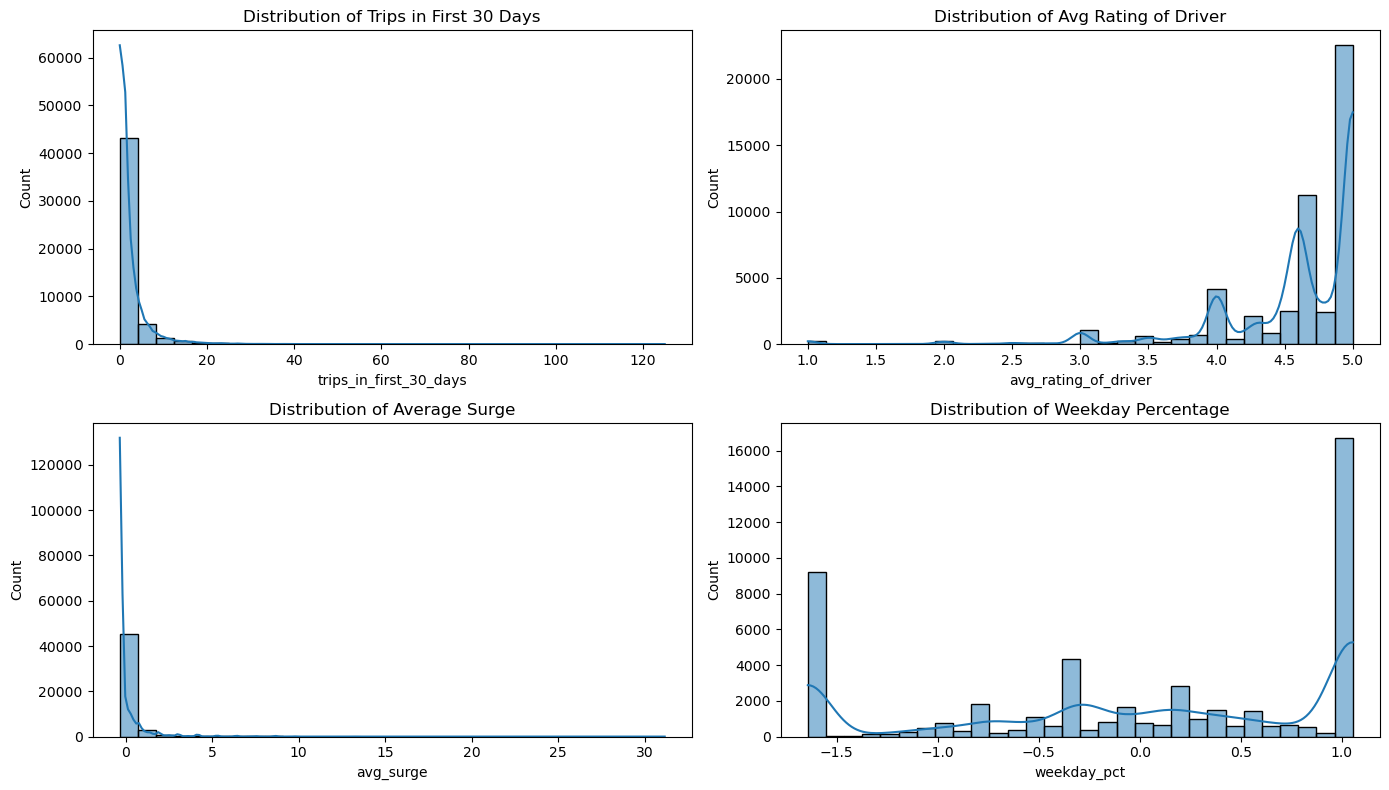

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize distribution of numeric features
plt.figure(figsize=(14, 8))

# Plot the distribution of trips in the first 30 days
plt.subplot(2, 2, 1)
sns.histplot(df['trips_in_first_30_days'], bins=30, kde=True)
plt.title('Distribution of Trips in First 30 Days')

# Plot the distribution of average rating of driver
plt.subplot(2, 2, 2)
sns.histplot(df['avg_rating_of_driver'], bins=30, kde=True)
plt.title('Distribution of Avg Rating of Driver')

# Plot the distribution of average surge
plt.subplot(2, 2, 3)
sns.histplot(df['avg_surge'], bins=30, kde=True)
plt.title('Distribution of Average Surge')

# Plot the distribution of weekday percentage
plt.subplot(2, 2, 4)
sns.histplot(df['weekday_pct'], bins=30, kde=True)
plt.title('Distribution of Weekday Percentage')

plt.tight_layout()
plt.show()

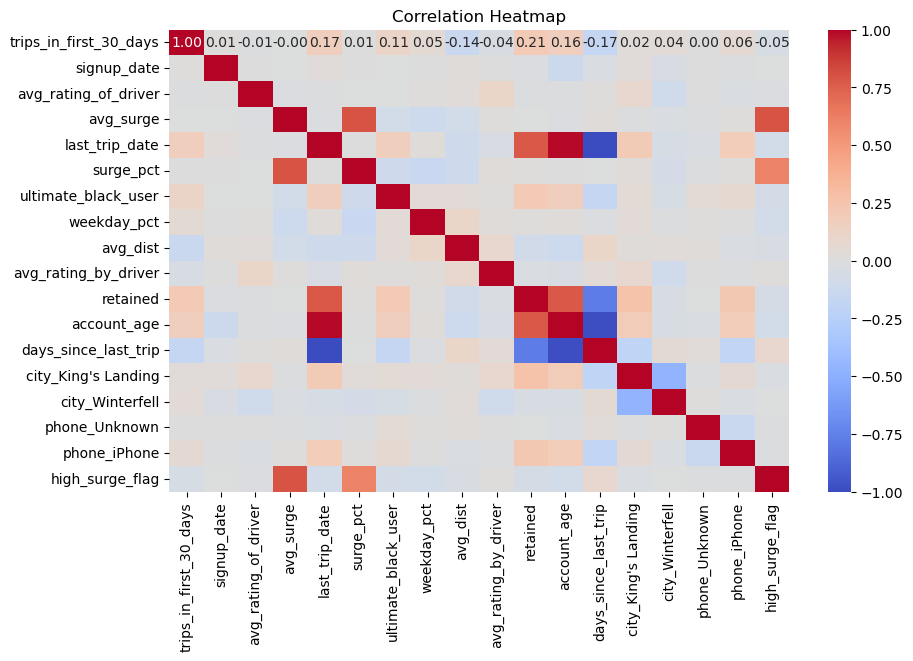

In [21]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

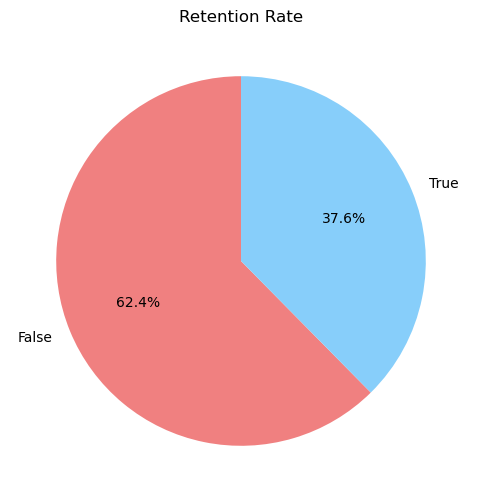

In [22]:
# Assuming we have a 'retained' column indicating retention (e.g., 1 for retained, 0 for not retained)
plt.figure(figsize=(6, 6))
df['retained'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
plt.title('Retention Rate')
plt.ylabel('')
plt.show()

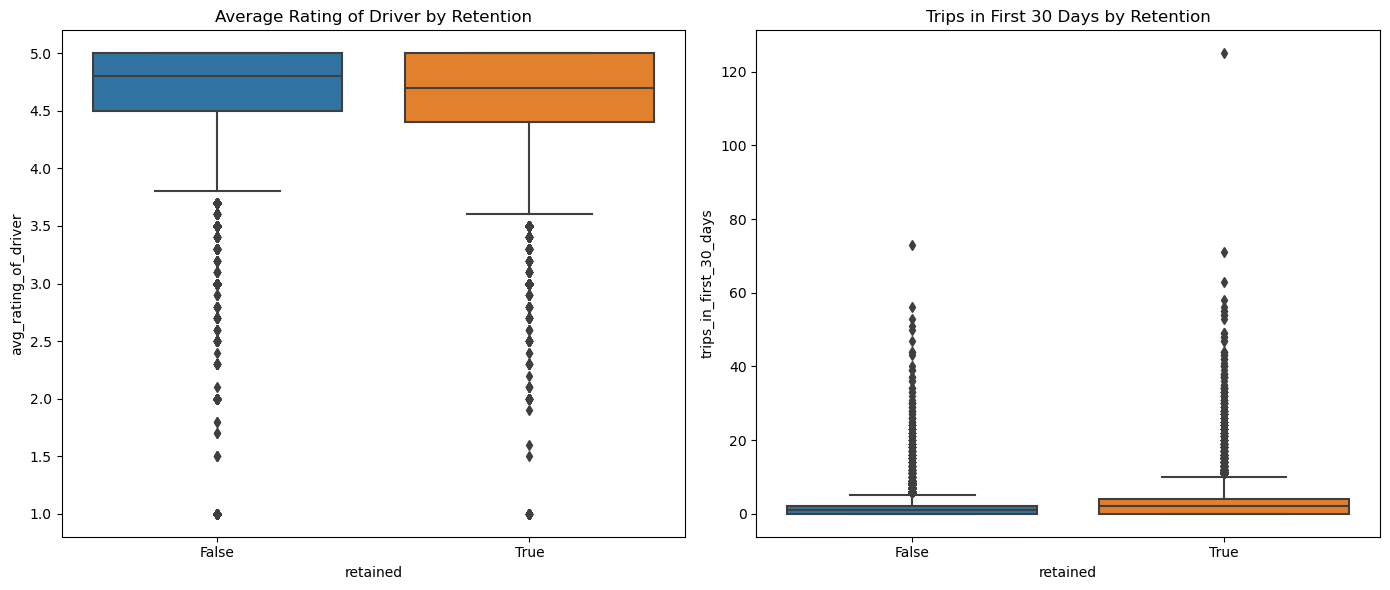

In [23]:
plt.figure(figsize=(14, 6))

# Plot avg rating of driver by retention
plt.subplot(1, 2, 1)
sns.boxplot(x='retained', y='avg_rating_of_driver', data=df)
plt.title('Average Rating of Driver by Retention')

# Plot trips in the first 30 days by retention
plt.subplot(1, 2, 2)
sns.boxplot(x='retained', y='trips_in_first_30_days', data=df)
plt.title('Trips in First 30 Days by Retention')

plt.tight_layout()
plt.show()

#### Predictive Model for User Retention (6th Month Activity)
##### 1. Problem Overview:
The goal is to predict whether a user will be active in the 6th month after signing up for Ultimate. This is a binary classification problem where we predict whether a user is retained (active) or not.

##### 2. Approach:
I will use Logistic Regression as the primary model for this task, considering its simplicity, interpretability, and effectiveness for binary classification problems. It also provides insights into how each feature influences the probability of retention, which is crucial for operationalizing insights.

I will also explore alternative models like Random Forest and XGBoost, which may perform better due to their ability to capture complex interactions between features.

##### 3. Model Selection:
Logistic Regression (Primary Model):
Why this model?

Simple and interpretable.
Suitable for binary classification tasks.
Helps understand the relationship between features and retention (provides coefficients indicating the impact of each feature).
Advantages:

Fast and efficient for large datasets.
Good for identifying significant predictors.

Limitations:

May not perform well if the relationships between features and the target are highly non-linear or complex.

Alternatives Considered:
Random Forest:
Handles non-linear relationships well.
Can automatically model interactions between features.
Provides feature importance, helping us understand which features are crucial for retention.
XGBoost:
An advanced boosting algorithm, often more accurate than Random Forest due to its ability to reduce bias and variance.
Handles missing data, non-linearities, and interactions more effectively.
Great for imbalanced datasets as it can prioritize recall or precision depending on the use case.

Concerns:

Random Forest and XGBoost may offer high accuracy but can be less interpretable, which could be a concern when explaining results to non-technical stakeholders.
Overfitting risk, especially with complex models like Random Forest and XGBoost, if the model is too tuned to training data.


##### 4. Feature Selection and Engineering:
Signup and Last Trip Dates: Engineered a feature to calculate how many months a user stayed active and whether they were active in the 6th month.
Phone Type: Categorical encoding (iPhone vs Android), which may have an impact on user behavior.
Trips in First 30 Days: More engaged users in the first 30 days are likely to stay active.
Average Rating: Used both the rating by drivers and of drivers to measure satisfaction.
Surge Percentage and Average Surge: These factors could influence a user’s decision to remain active depending on their tolerance for surge pricing.
Ultimate Black User: Whether the user took premium services might indicate loyalty or spending patterns.
Weekday Percent: Could indicate if users are using the service for commuting, a critical factor for long-term engagement.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df[['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_dist', 'weekday_pct', 'ultimate_black_user']]
y = df['retained']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Evaluate Logistic Regression
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Precision:", precision_score(y_test, y_pred_log_reg))
print("Recall:", recall_score(y_test, y_pred_log_reg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))

# Random Forest for comparison
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate Random Forest
print("\nRandom Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Logistic Regression Performance:
Accuracy: 0.6727
Precision: 0.6499409681227863
Recall: 0.2911928061359429
Confusion Matrix:
 [[5626  593]
 [2680 1101]]

Random Forest Performance:
Accuracy: 0.6947
Precision: 0.5947916666666667
Recall: 0.6040729965617562
Confusion Matrix:
 [[4663 1556]
 [1497 2284]]


In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

knn = KNeighborsClassifier()

# Fit the KNeighborsClassifier model on the scaled training data
knn.fit(X_train_scaled, y_train)

# Predict the target on the test data
y_pred_knn = knn.predict(X_test_scaled)

# Evaluate the model's performance
print("KNeighborsClassifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn))
print("Recall:", recall_score(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

KNeighborsClassifier Performance:
Accuracy: 0.6923
Precision: 0.6056422569027611
Recall: 0.5337212377677863
Confusion Matrix:
 [[4905 1314]
 [1763 2018]]
Classification Report:
               precision    recall  f1-score   support

       False       0.74      0.79      0.76      6219
        True       0.61      0.53      0.57      3781

    accuracy                           0.69     10000
   macro avg       0.67      0.66      0.66     10000
weighted avg       0.69      0.69      0.69     10000



In [30]:
# Importing necessary libraries
from sklearn.svm import SVC

# Initialize the SVM model
svm = SVC()

# Fit the SVM model on the scaled training data
svm.fit(X_train_scaled, y_train)

# Predict the target on the test data
y_pred_svm = svm.predict(X_test_scaled)

# Evaluate the model's performance
print("Support Vector Machine (SVM) Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

Support Vector Machine (SVM) Performance:
Accuracy: 0.7046
Precision: 0.6637623762376238
Recall: 0.4432689764612536
Confusion Matrix:
 [[5370  849]
 [2105 1676]]
Classification Report:
               precision    recall  f1-score   support

       False       0.72      0.86      0.78      6219
        True       0.66      0.44      0.53      3781

    accuracy                           0.70     10000
   macro avg       0.69      0.65      0.66     10000
weighted avg       0.70      0.70      0.69     10000



In [31]:
# Importing necessary libraries
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes model
nb = GaussianNB()

# Fit the Naive Bayes model on the training data (no need to scale for NB)
nb.fit(X_train, y_train)

# Predict the target on the test data
y_pred_nb = nb.predict(X_test)

# Evaluate the model's performance
print("Naive Bayes (NB) Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb))
print("Recall:", recall_score(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes (NB) Performance:
Accuracy: 0.6913
Precision: 0.6673095467695275
Recall: 0.36604072996561754
Confusion Matrix:
 [[5529  690]
 [2397 1384]]
Classification Report:
               precision    recall  f1-score   support

       False       0.70      0.89      0.78      6219
        True       0.67      0.37      0.47      3781

    accuracy                           0.69     10000
   macro avg       0.68      0.63      0.63     10000
weighted avg       0.69      0.69      0.66     10000



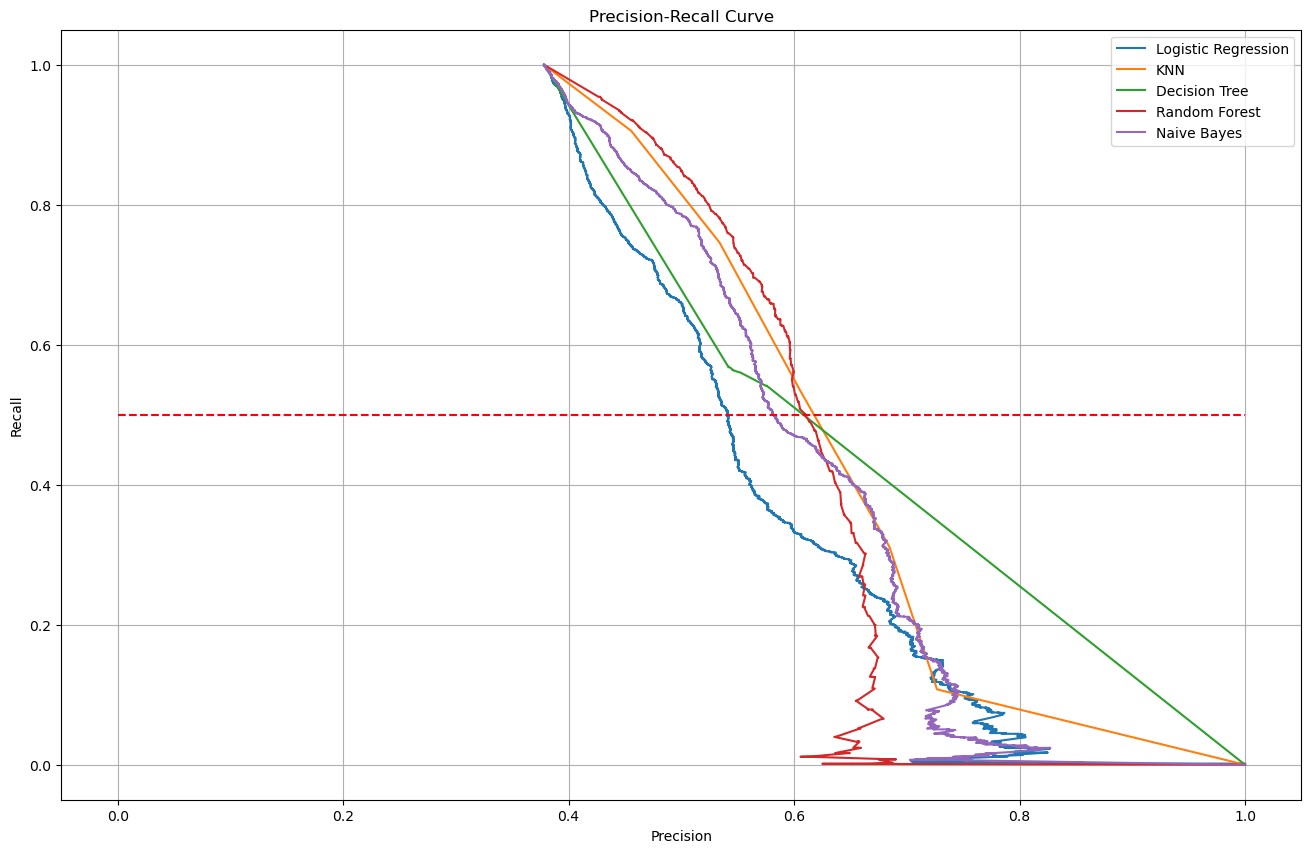

In [34]:
lr_cv = LogisticRegressionCV(cv=5, random_state=42)   # Logistic Regression with Cross-Validation
knn_cv = KNeighborsClassifier()                       # K-Nearest Neighbors
dt_cv = DecisionTreeClassifier(random_state=42)       # Decision Tree
rf_cv = RandomForestClassifier(random_state=42)       # Random Forest
nb = GaussianNB()                                     # Naive Bayes (No need for scaling)

# Fit models
lr_cv.fit(X_train_scaled, y_train)
knn_cv.fit(X_train_scaled, y_train)
dt_cv.fit(X_train_scaled, y_train)
rf_cv.fit(X_train_scaled, y_train)
nb.fit(X_train_scaled, y_train)

# Precision-Recall Curves
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=y_test, probas_pred=lr_cv.predict_proba(X_test_scaled)[:,1])
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_true=y_test, probas_pred=knn_cv.predict_proba(X_test_scaled)[:,1])
precision_dt, recall_dt, thresholds_dt = precision_recall_curve(y_true=y_test, probas_pred=dt_cv.predict_proba(X_test_scaled)[:,1])
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_true=y_test, probas_pred=rf_cv.predict_proba(X_test_scaled)[:,1])
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true=y_test, probas_pred=nb.predict_proba(X_test_scaled)[:,1])

# Plotting Precision-Recall Curves
fig, ax = plt.subplots(figsize=(16,10))

ax.plot(precision_lr, recall_lr, label='Logistic Regression')
ax.plot(precision_knn, recall_knn, label='KNN')
ax.plot(precision_dt, recall_dt, label='Decision Tree')
ax.plot(precision_rf, recall_rf, label='Random Forest')
ax.plot(precision_nb, recall_nb, label='Naive Bayes')

# Set plot labels, title, and a horizontal reference line
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.hlines(y=0.5, xmin=0, xmax=1, color='red', linestyle='--')  # Reference line at recall = 0.5
ax.legend()
ax.grid()

plt.show()

Based on the model evaluations, the Random Forest algorithm demonstrates the most balanced performance for predicting whether a user will be active in their 6th month. While Naive Bayes and Logistic Regression have higher precision, they suffer from lower recall, meaning they fail to capture a significant number of active users. The Support Vector Machine (SVM) and K-Nearest Neighbors (KNN) models perform moderately well, with SVM showing improved recall and KNN providing a decent balance between precision and recall. However, Random Forest stands out with its strong recall of 0.60 and balanced precision of 0.59, making it the most reliable model for accurately identifying both retained and non-retained users. This balanced performance is critical in ensuring that the model minimizes false positives and false negatives, making Random Forest the optimal choice for Ultimate's user retention prediction.

****
The validity of the models can be evaluated based on several performance metrics, such as accuracy, precision, recall, and the F1-score. These metrics provide insight into how well the model generalizes to new data and its ability to make reliable predictions.

##### Random Forest Performance:
* Accuracy: 69.47% – This indicates that approximately 69% of the predictions made by the model are correct.
* Precision: 0.59 – This means that when the model predicts a user is retained, it is correct 59% of the time.
* Recall: 0.60 – This shows that the model is able to correctly identify 60% of the users who were actually retained.
* F1-Score: The F1-score balances precision and recall, indicating the model’s effectiveness at predicting active users.
While the accuracy and precision are moderate, the recall score of 0.60 is notable as it suggests the model can successfully identify a substantial proportion of retained users. This balance of precision and recall, along with a decent accuracy, indicates that the model is reasonably valid for predicting user retention. However, improvements could be made by further tuning the model, using more features, or employing advanced techniques like ensemble learning.

Key indicators such as the confusion matrix further support the model’s performance by showing a balance between true positives and true negatives. Random Forest’s ability to generalize well is reflected in its competitive performance across multiple metrics, making it a valid choice for predicting rider retention.